In [1]:
%matplotlib inline
import importlib as imp
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True

import Calculate_ABA_Finkelsteinlab_Diewertje as CalcABA
imp.reload(CalcABA);
import plotting_ABA_Diewertje_deltaABA as pltABA
imp.reload(pltABA);
import plotting_Boyle_Diewertje as plt_B
imp.reload(plt_B);

import sys 
sys.path.append('../code_general/')
import CRISPR_free_energy_landscape_Diewertje as FreeEnergy
imp.reload(FreeEnergy);
import read_model_ID;
imp.reload(read_model_ID);

import sys 
sys.path.append('../code_general_Finkelsteinlab/')
import plotting_Finkelsteinlab as plt_F
imp.reload(plt_F)


import analysis_SA_fits_Diewertje as SAfits
imp.reload(SAfits);



In [47]:
simset3 = []
no_good = []
# Used concentrations: [10,100]
chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,14):
    sa = pd.read_csv('../Diewertje/12_6_2019_cas12_conc8/fit_12_6_2019_cas12_conc8_sim_' +str(sim)+'.txt', delimiter='\t', index_col=45)
    filename = '../Diewertje/12_6_2019_cas12_conc8/fit_12_6_2019_cas12_conc8_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset3.append(filename)
        
    
best_fit_conc3 = simset3[np.argmin(chi_squared)]
sim4='../Diewertje/12_6_2019_cas12_conc8/fit_12_6_2019_cas12_conc8_sim_4.txt'
sim2='../Diewertje/12_6_2019_cas12_conc8/fit_12_6_2019_cas12_conc8_sim_2.txt'

best_fit_conc3

'../Diewertje/12_6_2019_cas12_conc8/fit_12_6_2019_cas12_conc8_sim_13.txt'

In [36]:
print('The chi-squared of the best fit is:',chi_squared[0])

The chi-squared of the best fit is: 48179.8436614


In [37]:
chi_squared

[48179.8436614,
 53192.5547948,
 48716.776283499996,
 49478.5956314,
 59931.82350730001,
 51711.6024449,
 51961.7034171,
 48713.5445743,
 51061.3625702,
 50763.796403099994,
 50221.5890614,
 50056.2107412,
 48168.7500459]

In [38]:
# Load data
import Prepare_data as Pre
rawABA=pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas12a-target-d-replicate-1-delta-abas_Canonical_OT-r_0-2.csv')
rawABA

cas9=pd.read_csv('../Data_ABA_Finkelsteinlab/cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-2.csv')
x,_,_=Pre.Prepare_Cdata('../Data_ABA_Finkelsteinlab/','cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-2.csv')

# prepare data
path_to_data= '../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
filename= 'cas12a-target-d-replicate-1-delta-abas_Canonical_OT-r_0-2.csv'
xdata,ydata,yerr=Pre.Prepare_Cdata(path_to_data,filename) 


In [39]:
# Load Parameters to calculate the chi-squared for best fit
import get_parameters_fit_Diewertje as getParm
Nparams=44
concentrations=np.array([1,30,100])
Param_conc3=getParm.load_simm_anneal(best_fit_conc3,Nparams)

In [40]:
percentage=0.1,
model_id='general_energies_no_kPR'
path=path_to_data
replica='cas12a-target-d-replicate-1-delta-abas_Canonical_OT-r_0-2.csv'

import os
import numpy as np
import pandas as pd
import Boyle_data_processing as process
import CRISPR_dCas9_binding_curve_Boyle as dCas9
import matplotlib.pylab as plt
import Prepare_data as prep

import Calculate_ABA_Finkelsteinlab_Diewertje as ABA


# BASED ON ABA AVARAGE DATA AND PREDICTED ABA

def Weighted_average(row):
    y = np.array(row['ydata'])
    e = np.array(row['yerr'])
    wa=np.average(y, weights=e ** -2, axis=0)
    return wa


def calc_Weighted_average(path='../Data_Boyle/', replica='1', outputdirectory='../Data_Boyle/Weighted_Avarage/',
                          save=True):
    # For me replica is the filename
    xdata, ydata, yerr = prep.Prepare_Cdata(path=path,filename=replica)
    data = pd.DataFrame(columns=['xdata', 'ydata', 'yerr'])
    data['xdata'] = xdata
    data['ydata'] = ydata
    data['yerr'] = yerr
    wa = []
    for i in data.index:
        wa.append(Weighted_average(data.loc[i]))
    #data['WA'] = wa
    #data['WA'] = data.apply(Weighted_average, axis=1)

    WA = pd.DataFrame(columns=['MM_pos', 'WA_data'])
    WA.MM_pos = xdata
    WA.WA_data = wa
    return WA


def predict_train(parameters, model_id='general_energies_no_kPR', path='../Data_Boyle/', replica='1', Plot=True):
    wa = calc_Weighted_average(path=path, replica=replica, save=False)
    prediction=wa.copy()
    concentrations=np.array([0.1,0.3,1.,3.,10.,30.,100.,300.])
    reference=1
    prediction['WA_model']=wa['MM_pos'].apply(lambda x: ABA.calc_ABA(parameters,concentrations,reference,x.tolist(),model_id,guide_length=20,T=10*60))
    score = prediction.dropna().apply(lambda x: np.abs(x['WA_data'] - x['WA_model']) / x['WA_data'], axis=1).mean()
    corr=0
    return score, corr, prediction


WA=calc_Weighted_average(path,replica,save=False)
WA['WA_data_delta']=WA['WA_data']#-2.5545002878227865 
# substract ontarget to go to delta ABA


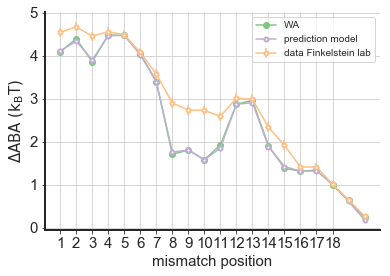

In [41]:
WAsingle=[]
singlePos=[]
for i in range(len(WA)):
    if (len(WA['MM_pos'][i])==1):
        singlePos.append(WA['MM_pos'][i])
        WAsingle.append(WA['WA_data_delta'][i])

T=60*10
guide_length=20
model_id = 'general_energies_no_kPR'
        
WAsingle_ordered=np.empty(len(WAsingle)+1)
for i in range(1,len(WAsingle)+1):
    WAsingle_ordered[singlePos[i-1]]=WAsingle[i-1]
len(WAsingle_ordered)
plt.figure()
plt.plot(range(1,21),WAsingle_ordered[1:],marker='o',label='WA')
delta1 = pltABA.predict_single_mm(Param_conc3,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
plt.legend()
plt.grid()

# THIS IS CALCULATED WITH 9 POINTS!!

Text(0.5, 1.0, 'Prediction (top) / WA (bottom)')

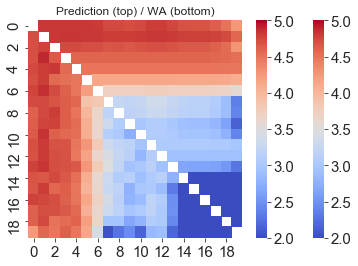

In [42]:
#-----For double mismatches-----
WAdouble=[]
doublePos=[]
for i in range(len(WA)):
    if (len(WA['MM_pos'][i])==2):
        doublePos.append(WA['MM_pos'][i])
        WAdouble.append(WA['WA_data'][i])
mapABA=np.zeros([20,20])
mapABA[:]=np.nan
for i in range(len(doublePos)):
    mapABA[doublePos[i][0]-1,doublePos[i][1]-1]=WAdouble[i]

import seaborn as sns
plt.figure()
best_heatmap = pltABA.predict_double_mm(Param_conc3,model_id,T, guide_length, show_plot=True, show_data=False, data_file=rawABA)

sns.heatmap(mapABA.transpose(), cmap='coolwarm', cbar=True, vmin=2,vmax=5)
plt.title('Prediction (top) / WA (bottom)')

# THIS IS CALCULATED WITH 9 POINTS!!

In [48]:
# --- make selection --- 
selected_sims_chi=np.array(simset3)[(np.array(chi_squared)<50500)]

simset3 = selected_sims_chi 

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset3,44,'general_energies_no_kPR')
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]
matches.loc[best_fit_conc3]

PAM    3.500000
1     -7.454791
2      5.254943
3      0.345955
4     -0.165545
5      1.478787
6      0.509398
7      0.358383
8     -1.728179
9      1.599668
10    -4.892190
11     2.692731
12     1.810751
13     0.637949
14     2.662526
15    -1.840746
16    -7.515724
17     7.491108
18     2.541347
19    -5.253708
20     7.851207
Name: ../Diewertje/12_6_2019_cas12_conc8/fit_12_6_2019_cas12_conc8_sim_13.txt, dtype: float64

<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>


C:\Users\Diewertje\Python\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


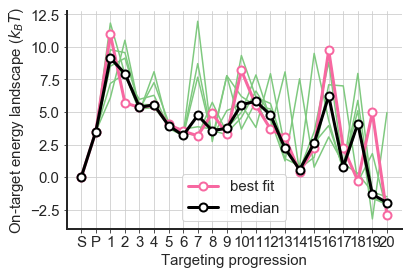

In [49]:
# --- (microscopic) free-energy landscape --- 
plt.figure()
Nparams=41
for filename in simset3:
    print(type(filename))
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    parameters[0]=3.5 # if want to fix epsilon PAM
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id='fixed_rates',show_plot=False);
    #plt.figure()
    plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])
lowest_chi_squared = np.array( landscape.loc[best_fit_conc3] )


plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
         marker='o', 
         lw=3,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='best fit');

LandscapeMED = landscape[landscape.columns[:]].median()
plt.plot(np.array(LandscapeMED),color='black' , 
         marker='o',
         lw=3,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='median');

# plot best fit eq in this fit
# fit_eq=getParm.load_simm_anneal('../Diewertje/26_5_2019_cas12_conc3_eq/fit_26_5_2019_cas12_conc3_eq_sim_5.txt',44)
# Energy_landscape_eq, FreeEnergy_landscape_eq = FreeEnergy.plot_free_energy_landscape(fit_eq,model_id=model_id,show_plot=False);
# #plt.figure()
# plt.plot(np.array(Energy_landscape_eq),color='b',marker='o')


plt.legend(fontsize=15,frameon=True)
plt.xlim(-1,22)
plt.xticks(list(range(0,22)),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine();


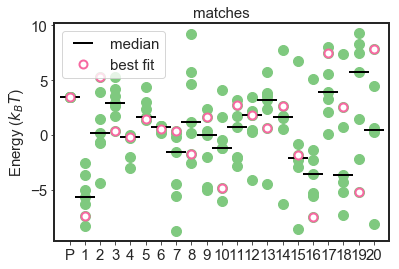

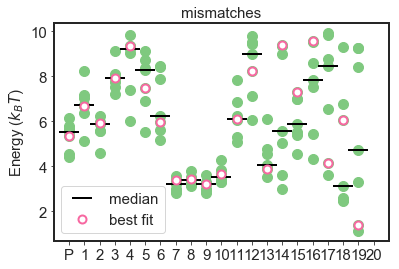

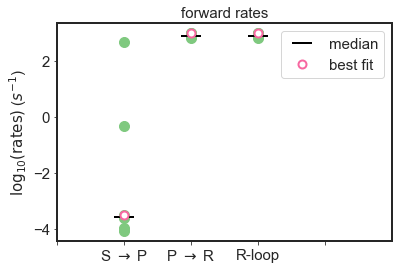

In [50]:
# ---- show fluctuations in parameter sets --- 
# THIS IS THE RESULT

# --- Matches ---
# MAYBE WE WANT TO NEGATE (multiply by -1 all the epsilonC to have the same sign convention as EpsilonPAM and EpsilonI)
plt.figure()
for sim in simset3:
    matches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

matches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    

matches.loc[best_fit_conc3].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('matches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

# --- Mismatches --- 
plt.figure()
for sim in simset3:
    mismatches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

mismatches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    

mismatches.loc[best_fit_conc3].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('mismatches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);


# --- 10log of the forward rates --- 
plt.figure()
for sim in simset3:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

forward_rates.loc[best_fit_conc3].apply(np.log10).plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

# INSIDE THE FUNCTION EPS(pam) IS STILL FIXED ON 3.5, SHOULD ADJUST THIS!


In [51]:
epsPAM=[]
ontarget_ABA=[]

for sim in simset3:
    concentrations=np.array([0.1,0.3,1,3,10,30,100,300])
    Param=getParm.load_simm_anneal(sim,Nparams)
    epsPAM.append(Param[0])
    ontarget_ABA.append(CalcABA.calc_ABA(Param, concentrations, reference=1,
                                    mismatch_positions=[],
                                    model_id=model_id,
                                    guide_length=20,
                                    T=60 * 10))
print(epsPAM)
print(ontarget_ABA)

[7.66472191701, 6.55931869923, 7.33813106935, 2.85560875647, 9.38838237093, 6.37376368792, 6.58163735016]
[2.8726539151328905, 1.7619005122619846, 2.5811167426823474, -1.9729661217568297, 4.512499073913925, 1.6048454498533613, 1.7442835009881117]


In [52]:
def plot_single_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):

    Mut_names = {'r':'Mismatch', 'i':'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]
    
    data['Mutation Type'].fillna('', inplace=True)
    single_mut_data = data[(data['Canonical']==Canonical)&(data['Mutation Type']==Mut_type)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    single_mut_data['Position'] = single_mut_data['Mutation ID'].apply(lambda x: int(x.split(':')[1]))
    single_mut_data_mean = single_mut_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()
    
    if Plot:
        single_mut_data_mean.plot(x='Position', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
        plt.xlabel(Mut_name+' postion', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
        if not Canonical:
            plt.title(data_name + ' - Noncanonical',fontsize=15)
    
    return single_mut_data_mean

def plot_double_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):
    
    Mut_names = {'r':'Mismatch', 'i':'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]
    Mut_type_str = Mut_type+'|'+Mut_type
    
    data['Mutation Type'].fillna('', inplace=True)
    double_mut_data = data[(data['Canonical']==Canonical)&(data['Mutation Type']==Mut_type_str)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    double_mut_data['Position'] = double_mut_data['Mutation ID'].apply(lambda x: '|'.join(map(lambda y: y.split(':')[1], x.split('|'))))
    double_mut_data_mean = double_mut_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    double_mut_map = np.empty((Ng,Ng))
    double_mut_map[:] = np.nan
    for n in range(len(double_mut_data_mean)):
        pos = double_mut_data_mean['Position'].iloc[n]
        Positions = list(map(lambda x: int(x)-1, pos.split('|')))
        double_mut_map[Positions[1],Positions[0]] = double_mut_data_mean['Delta ABA (kBT)'].iloc[n]
        
    if Plot:    
        plt.figure()
        sns.heatmap(double_mut_map, cmap='coolwarm',cbar=True,vmin=0,vmax=double_mut_data_mean['Delta ABA (kBT)'].max())
        plt.xlabel(Mut_name+' 1', fontsize=15)
        plt.ylabel(Mut_name+' 2', fontsize=15)
        plt.title('$\Delta$ABA - '+data_name,fontsize=15)
        if not Canonical:
            plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
        ax = plt.gca()
        ax.set_xticklabels(list(map(lambda x: str(int(x)),ax.get_xticks()+0.5)));
        ax.set_yticklabels(list(map(lambda x: str(int(x)),ax.get_yticks()+0.5)));
    
    return double_mut_data_mean, double_mut_map

def make_block_ID(MM_pos_list):
    
    bi = MM_pos_list[0]
    bf = MM_pos_list[-1]
    block = np.arange(bi,bf+1)
    if (len(block)!=len(MM_pos_list)) or np.any(block!=np.array(MM_pos_list)):
        return ''
    return '|'.join(list(map(str, [bi, bf])))

def plot_block_mm_ABA(data, data_name='Finkelstein Data', Canonical=True, Plot=True):
    
    data['Mutation Type'].fillna('', inplace=True)
    select_multi_mm = data['Mutation Type'].apply(lambda x: np.unique(np.array(x.split('|')))[0]=='r')
    multi_mm_data = data[(data['Canonical']==Canonical)&(select_multi_mm)&(data['Mutation Count']>2)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    multi_mm_data['MM Positions'] = multi_mm_data['Mutation ID'].apply(lambda x: list(map(lambda y: int(y.split(':')[1]), x.split('|'))))
    multi_mm_data['Position'] = multi_mm_data['MM Positions'].apply(make_block_ID)
    multi_mm_data = multi_mm_data[(multi_mm_data['Position']!='')]
    block_mm_data_mean = multi_mm_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    block_mm_map = np.empty((Ng,Ng))
    block_mm_map[:] = np.nan
    for n in range(len(block_mm_data_mean)):
        pos = block_mm_data_mean['Position'].iloc[n]
        Positions = list(map(lambda x: int(x)-1, pos.split('|')))
        block_mm_map[Positions[0],Positions[1]] = block_mm_data_mean['Delta ABA (kBT)'].iloc[n]

    if Plot:
        plt.figure()
        sns.heatmap(block_mm_map, cmap='coolwarm',cbar=True,vmin=2,vmax=5) #=block_mm_data_mean['Delta ABA (kBT)'].max())
        #plt.xlabel('Block end', fontsize=15)
        #plt.ylabel('Block start', fontsize=15)
        plt.title('$\Delta$ABA - '+data_name,fontsize=15)
        if not Canonical:
            plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
        ax = plt.gca()
        ax.set_xticklabels(list(map(lambda x: str(int(x)),ax.get_xticks()+0.5)));
        ax.set_yticklabels(list(map(lambda x: str(int(x)),ax.get_yticks()+0.5)));
    
    block_start_mm_data = block_mm_data_mean.set_index('Position').groupby(lambda x: int(x.split('|')[0])).mean().reset_index().rename(columns={'index':'Block start'})
    
    if Plot:
        block_start_mm_data.plot(x='Block start', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
        #plt.xlabel('Block start', fontsize=15)
        #plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
        if not Canonical:
            plt.title(data_name+' - Noncanonical',fontsize=15)
    
    return block_mm_data_mean, block_mm_map, block_start_mm_data

def plot_block_mm_ABA_WA(data, data_name='Finkelstein Data', Canonical=True, Plot=True):
    
    data['Mutation Type'].fillna('', inplace=True)
    select_multi_mm = data['Mutation Type'].apply(lambda x: np.unique(np.array(x.split('|')))[0]=='r')
    multi_mm_data = data[(data['Canonical']==Canonical)&(select_multi_mm)&(data['Mutation Count']>2)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    multi_mm_data['MM Positions'] = multi_mm_data['Mutation ID'].apply(lambda x: list(map(lambda y: int(y.split(':')[1]), x.split('|'))))
    multi_mm_data['Position'] = multi_mm_data['MM Positions'].apply(make_block_ID)
    multi_mm_data = multi_mm_data[(multi_mm_data['Position']!='')]
    data['Mutation Type'].fillna('', inplace=True)
    select_multi_mm = data['Mutation Type'].apply(lambda x: np.unique(np.array(x.split('|')))[0]=='r')
    multi_mm_data = data[(data['Canonical']==Canonical)&(select_multi_mm)&(data['Mutation Count']>2)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    multi_mm_data['MM Positions'] = multi_mm_data['Mutation ID'].apply(lambda x: list(map(lambda y: int(y.split(':')[1]), x.split('|'))))
    multi_mm_data['Position'] = multi_mm_data['MM Positions'].apply(make_block_ID)
    multi_mm_data = multi_mm_data[(multi_mm_data['Position']!='')]
    block_mm_data_mean = multi_mm_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position')
    ydata=[]
    yerr=[]
    pos=[]
    for blockID, group in block_mm_data_mean:
        yvals=[]
        yerval=[]
        for i in range(len(group)):
            yvals.append(group['Delta ABA (kBT)'].iloc[i])
            yerval.append(group['Uncertainty'].iloc[i])
        pos.append(group['Position'].iloc[i])
        ydata.append(yvals)
        yerr.append(yerval)

    wa=[]
    for i in range(len(pos)):
        y = np.array(ydata[i])
        e = np.array(yerr[i])
        wa.append(np.average(y, weights=e ** -2, axis=0))

    block_mm_data_mean=pd.DataFrame({'Position':pd.Series(pos),'Delta ABA (kBT)':pd.Series(wa)})
    
    Ng = 20;
    block_mm_map = np.empty((Ng,Ng))
    block_mm_map[:] = np.nan
#     for n in range(len(ydata)):
#         pos = pos[n]
#         Positions = list(map(lambda x: int(x)-1, pos.split('|')))
#         block_mm_map[Positions[0],Positions[1]] = wa[n]

#     if Plot:
#         plt.figure()
#         sns.heatmap(block_mm_map, cmap='coolwarm',cbar=True,vmin=2,vmax=5) #=block_mm_data_mean['Delta ABA (kBT)'].max())
#         #plt.xlabel('Block end', fontsize=15)
#         #plt.ylabel('Block start', fontsize=15)
#         plt.title('$\Delta$ABA - '+data_name,fontsize=15)
#         if not Canonical:
#             plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
#         ax = plt.gca()
#         ax.set_xticklabels(list(map(lambda x: str(int(x)),ax.get_xticks()+0.5)));
#         ax.set_yticklabels(list(map(lambda x: str(int(x)),ax.get_yticks()+0.5)));
    
    block_start_mm_data = pd.DataFrame(block_mm_data_mean).set_index('Position').groupby(lambda x: int(x.split('|')[0])).mean().reset_index().rename(columns={'index':'Block start'})
    if Plot:
        block_start_mm_data.plot(x='Block start', y='Delta ABA (kBT)', marker='o', linewidth=1, color='blue') 
        #plt.xlabel('Block start', fontsize=15)
        #plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
        if not Canonical:
            plt.title(data_name+' - Noncanonical',fontsize=15)
    
    return block_mm_data_mean, block_mm_map, block_start_mm_data

def plot_mut_PAM_ABA(data, data_name='Finkelstein Data', Plot=True):
    
    data['Mutation Type'].fillna('', inplace=True)
    data['Alignment'].fillna('', inplace=True)
    NonCanonical = data[(data['Canonical']==False)&(data['Alignment']!='')&(data['Mutation Type']=='')][['PAM', 'Delta ABA (kBT)', 'Uncertainty']].groupby('PAM').mean()
    
    if Plot:
        bar_width = 0.35
        plt.figure(figsize=(20,6))
        plt.bar(np.arange(len(NonCanonical)), NonCanonical['Delta ABA (kBT)'], width=bar_width)
        ax = plt.gca()
        ax.set_xticks(np.arange(len(NonCanonical))+0.5*bar_width);
        ax.set_xticklabels(NonCanonical.index, rotation='vertical');
        #plt.xlabel('PAM', fontsize=15)
        #plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
    
    return NonCanonical

20


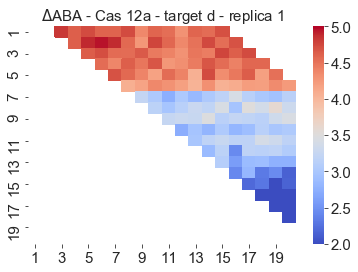

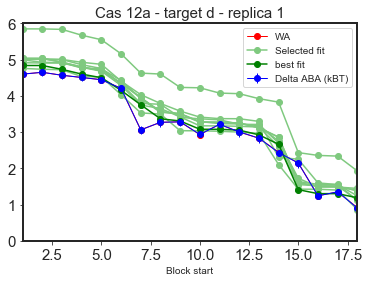

In [53]:
ontarget_ABA_best = CalcABA.calc_ABA(Param_conc3, concentrations, reference=1,
                                    mismatch_positions=[],
                                    model_id=model_id,
                                    guide_length=20,
                                    T=60 * 10)
    
energy_block_b=[]
epsilon = Param_conc3[:-2]
for mmStart in range(1,21):
    block=np.arange(mmStart,21)
    energies=ABA.get_energies(epsilon,block, guide_length)
    energy_block_b.append(-np.log(np.sum(np.exp(-np.cumsum(energies))))-ontarget_ABA_best)
print(len(energy_block))   

#plt.xlabel('Start mismatch block')

Path = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
filename_3 = 'cas12a-target-d-replicate-1-delta-abas-processed.csv'
data_cas12a_d1 = pd.read_csv(Path+filename_3)
_, block_cas12a_d, block_start_cas12_d2 = plot_block_mm_ABA(data_cas12a_d1, data_name='Cas 12a - target d - replica 1', Canonical=True, Plot=True)
_, block_cas12a_d_WA, block_start_cas12_d2_WA = plot_block_mm_ABA_WA(data_cas12a_d1, data_name='Cas 12a - target d - replica 1', Canonical=True, Plot=False)
plt.plot(block_start_cas12_d2_WA['Block start'], block_start_cas12_d2_WA['Delta ABA (kBT)'], marker='o', linewidth=1, color='red',label='WA') 

epsPAM=[]
rates=[]
# Also plot all the selected fits
for sim in simset3:
    concentrations=np.array([1,30,100])
    Param=getParm.load_simm_anneal(sim,Nparams)
    epsPAM.append(Param[0])
    rates.append([Param[-2],Param[-1]])
    ontarget_ABA_sim = CalcABA.calc_ABA(Param, concentrations, reference=1,
                                    mismatch_positions=[],
                                    model_id=model_id,
                                    guide_length=20,
                                    T=60 * 10)
    energy_block=[]
    epsilon = Param[:-2]
    for mmStart in range(1,21):
        block=np.arange(mmStart,21)
        energies=ABA.get_energies(epsilon,block, guide_length)
        energy_block.append(-np.log(np.sum(np.exp(-np.cumsum(energies))))-ontarget_ABA_sim)
    
    plt.plot(range(1,21),energy_block,marker='o',color=sns.color_palette()[0])

plt.plot(range(1,21),energy_block,marker='o',color=sns.color_palette()[0],label='Selected fit')
plt.plot(range(1,21),energy_block_b,marker='o',label='best fit',color='green')
plt.ylim(0,6)

plt.legend()